In [1]:
pip install yfinance pandas matplotlib numpy scikit-learn tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error

In [3]:
import pandas as pd

data = pd.read_csv('/content/nepse.csv')

# Reverse the order of rows
data = data.iloc[::-1].reset_index(drop=True)

In [4]:
data

,Date,Index Price
0,2014/02/02,775.92
1,2014/02/03,769.51
2,2014/02/04,774.91
3,2014/02/05,781.38
4,2014/02/06,785.78
...,...,...
2522,2025/02/25,2765.88
2523,2025/02/27,2815.04
2524,2025/03/02,2890.28
2525,2025/03/03,2876.66


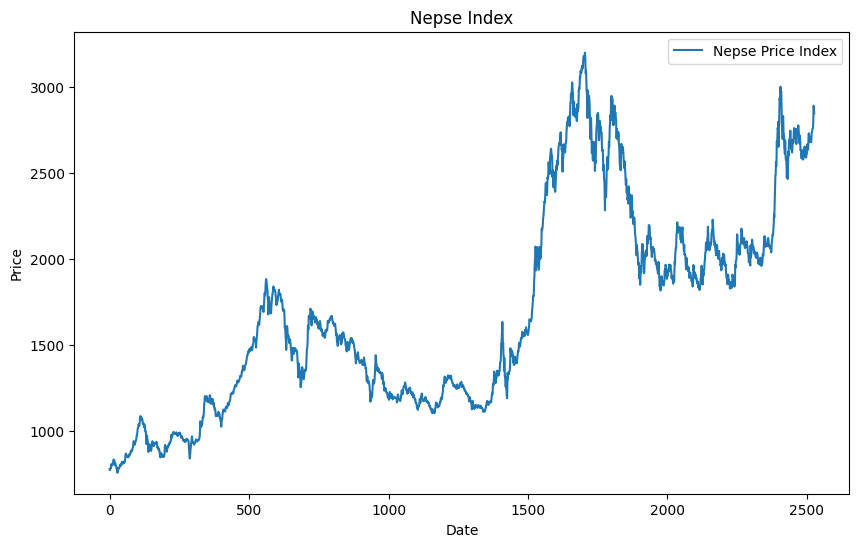

In [5]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Index Price'], label='Nepse Price Index')
plt.title("Nepse Index")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [6]:
# Reshape using numpy
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Index Price'].values.reshape(-1, 1))

In [7]:
scaled_data.shape

(2527, 1)

In [8]:
# Create sequences of 30 days of stock prices as input and the next day as output
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split into train, validation, and test sets (80%, 10%, 10%)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [9]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((1997, 30, 1), (1997, 1), (249, 30, 1), (249, 1), (251, 30, 1), (251, 1))

In [ ]:
X_train,y_train

In [11]:
#comparing transformer model with RNN,LSTM,GRU,BiLSTM

def rnn_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.SimpleRNN(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.SimpleRNN(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.LSTM(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def gru_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.GRU(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.GRU(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def bidirectional_lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=64, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Complete Transformer Model function to match the interface of other models
def transformer_model(seq_len, feature_dim=1, units=64):
    # Set transformer-specific parameters
    d_model = units
    num_heads = 4
    num_layers = 2
    dropout = 0.1

    inputs = layers.Input(shape=(seq_len, feature_dim))

    # Embedding
    x = layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        x = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)(x)

    # Final dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Training function
def train_model(model_func, model_name, X_train, y_train, X_val, y_val, sequence_length, epochs=50, batch_size=32):
    # Create model
    model = model_func(sequence_length)

    # Print model summary
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                min_lr=1e-6,
                                verbose=1)
    callbacks = [early_stopping, checkpoint, reduce_lr]

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Load the best model
    if model_name == 'Transformer':
        new_model = model_func(sequence_length)

        # Trying to load just the weights
        try:
            new_model.load_weights(f'best_{model_name}_model.h5')
            print("Weights loaded successfully!")
            model = new_model
        except Exception as e:
            print(f"Error loading weights: {e}")
            print("Using model with best weights from training session")
    else:
        # Original loading for other models
        model = tf.keras.models.load_model(f'best_{model_name}_model.h5')

    return model, history

# Evaluation function
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # Function to calculate MAE and MAPE
    def evaluate_mae_mape(y_true, y_pred):
        # Calculate MAE
        mae = mean_absolute_error(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        return mae, mape

    # Inverse transform to original scale
    train_pred = scaler.inverse_transform(train_pred)
    val_pred = scaler.inverse_transform(val_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate for training data
    train_mae, train_mape = evaluate_mae_mape(y_train_orig, train_pred)
    print(f"{model_name} - Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

    # Evaluate for validation data
    val_mae, val_mape = evaluate_mae_mape(y_val_orig, val_pred)
    print(f"{model_name} - Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

    # Evaluate for test data
    test_mae, test_mape = evaluate_mae_mape(y_test_orig, test_pred)
    print(f"{model_name} - Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

    results = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred,
        'y_train': y_train_orig,
        'y_val': y_val_orig,
        'y_test': y_test_orig,
        'metrics': {
            'train_mae': train_mae,
            'train_mape': train_mape,
            'val_mae': val_mae,
            'val_mape': val_mape,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    }

    return results

# Function to predict future values (next 7 days)
def predict_future(model, model_name, last_sequence, scaler, sequence_length, days_to_predict=30):
    print(f"\n{'-'*50}")
    print(f"Predicting next {days_to_predict} days using {model_name} model...")
    print(f"{'-'*50}")

    # Initialize with the last known sequence
    curr_sequence = last_sequence.copy()
    future_predictions = []
    future_dates = []

    # Get the last known date
    # Assuming the last date is the last day of test data
    last_date = pd.Timestamp.now()  # As a placeholder, you would set this to your last actual date

    # Predict one day at a time and update the sequence
    for i in range(days_to_predict):
        # Make prediction for the next day
        next_day_scaled = model.predict(curr_sequence.reshape(1, sequence_length, 1))
        next_day = scaler.inverse_transform(next_day_scaled)[0, 0]

        # Add the prediction to our results
        future_predictions.append(next_day)

        # Calculate the next date
        next_date = last_date + pd.Timedelta(days=i+1)
        future_dates.append(next_date)

        # Update sequence for next prediction (remove oldest, add newest prediction)
        next_day_scaled = next_day_scaled.reshape(1, 1)
        curr_sequence = np.append(curr_sequence[1:], next_day_scaled)

        # Print the prediction
        print(f"Day {i+1} ({next_date.strftime('%Y-%m-%d')}): Predicted Price = Rs.{next_day:.2f}")

    return future_predictions, future_dates

# Visualization function - combined plot
def plot_predictions(results, model_name, stock_name="Stock"):
    # Extract data
    y_train = results['y_train']
    y_val = results['y_val']
    y_test = results['y_test']
    train_pred = results['train_pred']
    val_pred = results['val_pred']
    test_pred = results['test_pred']

    # Check if future predictions exist in results
    has_future = 'future_pred' in results and 'future_dates' in results
    future_pred = results.get('future_pred', [])

    # Plot combined results
    plt.figure(figsize=(15, 8))

    # Actual data
    plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)),
             y_test, color='green', label='Test Data')

    # Predictions
    plt.plot(np.arange(len(train_pred)), train_pred, color='lightgreen', linestyle='--', label='Training Prediction')
    plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)),
             val_pred, color='black', linestyle='--', label='Validation Prediction')
    plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)),
             test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions if available
    if has_future:
        future_start_idx = len(y_train) + len(y_val) + len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Price Prediction using {model_name} - All Data")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_all_prediction.png")
    plt.show()

    # Validation Plot
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_val)), y_val, color='blue', label='Actual Validation Data')
    plt.plot(np.arange(len(val_pred)), val_pred, color='red', linestyle='--', label='Validation Prediction')
    plt.title(f"{stock_name} Validation Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_validation_prediction.png")
    plt.show()

    # Test Plot with Future Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, color='green', label='Actual Test Data')
    plt.plot(np.arange(len(test_pred)), test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions to the test plot
    if has_future:
        future_start_idx = len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Test Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_test_prediction.png")
    plt.show()

# Compare model performances
def compare_models(model_results, stock_name="Stock"):
    models = list(model_results.keys())

    # Create metrics dataframe
    metrics_data = []
    for model_name, results in model_results.items():
        metrics = results['metrics']
        metrics_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Train MAPE (%)': metrics['train_mape'],
            'Val MAE': metrics['val_mae'],
            'Val MAPE (%)': metrics['val_mape'],
            'Test MAE': metrics['test_mae'],
            'Test MAPE (%)': metrics['test_mape']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Plot MAE and MAPE comparison
    plt.figure(figsize=(14, 6))

    # Bar chart for MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width, [model_results[m]['metrics']['train_mae'] for m in models],
            width, label='Train MAE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mae'] for m in models],
            width, label='Val MAE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mae'] for m in models],
            width, label='Test MAE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'{stock_name} Price Prediction - MAE Comparison')
    plt.xticks(x, models)
    plt.legend()

    # Bar chart for MAPE
    plt.subplot(1, 2, 2)
    plt.bar(x - width, [model_results[m]['metrics']['train_mape'] for m in models],
            width, label='Train MAPE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mape'] for m in models],
            width, label='Val MAPE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mape'] for m in models],
            width, label='Test MAPE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAPE (%)')
    plt.title(f'{stock_name} Price Prediction - MAPE Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{stock_name}_model_comparison.png")
    plt.show()

    # Removed the future predictions comparison plot and related code

    return metrics_df, None  # Return None for future_df

# Main function to run the entire process
def run_models(X_train, y_train, X_val, y_val, X_test, y_test,
               sequence_length, scaler, raw_data=None, epochs=50, batch_size=32, stock_name="Apple"):
    # Model architectures dictionary
    model_builders = {
        'RNN': rnn_model,
        'LSTM': lstm_model,
        'GRU': gru_model,
        'BiLSTM': bidirectional_lstm_model,
        'Transformer': transformer_model
    }

    # Train and evaluate all models
    model_results = {}

    # Get the last sequence from test data for future predictions
    last_sequence = X_test[-1].copy()  # The last sequence from test data

    for model_name, model_func in model_builders.items():
        # Train
        trained_model, history = train_model(
            model_func, model_name, X_train, y_train, X_val, y_val,
            sequence_length, epochs, batch_size
        )

        # Evaluate
        results = evaluate_model(
            trained_model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler
        )

        # Predict future 7 days
        future_pred, future_dates = predict_future(
            trained_model, model_name, last_sequence, scaler, sequence_length, days_to_predict=7
        )

        # Add future predictions to results
        results['future_pred'] = future_pred
        results['future_dates'] = future_dates

        # Store results
        model_results[model_name] = results

        # Plot individual model results
        plot_predictions(results, model_name, stock_name)

    # Compare all models
    metrics_df, future_df = compare_models(model_results, stock_name)

    return model_results, metrics_df, future_df

# Helper function to prepare data and execute the pipeline
def prepare_and_run(stock_data, target_column='Close', test_size=0.2, val_size=0.2,
                    sequence_length=60, epochs=50, batch_size=32, stock_name="Stock"):
    # Assuming stock_data is a DataFrame with at least the target_column
    data = stock_data[[target_column]].values

    # Scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])

    X, y = np.array(X), np.array(y)

    # Reshape X for model input: [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split data into train, validation and test sets
    train_size = int(len(X) * (1 - test_size - val_size))
    val_size = int(len(X) * val_size)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

    print(f"Data shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Data shapes - X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Data shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Run models
    model_results, metrics_df, future_df = run_models(
        X_train, y_train, X_val, y_val, X_test, y_test,
        sequence_length, scaler, raw_data=stock_data,
        epochs=epochs, batch_size=batch_size, stock_name=stock_name
    )

    return model_results, metrics_df, future_df


Training RNN model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 30, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0344 - mae: 0.1319
Epoch 1: val_loss improved from inf to 0.00116, saving model to best_RNN_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0341 - mae: 0.1312 - val_loss: 0.0012 - val_mae: 0.0280 - learning_rate: 0.0010
Epoch 2/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0463
Epoch 2: val_loss improved from 0.00116 to 0.00086, saving model to best_RNN_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0041 - mae: 0.0459 - val_loss: 8.5952e-04 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 3/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mae: 0.0375
Epoch 3: val_loss did not improve from 0.00086
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mae: 0.0374 - val_loss: 0.0020 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 4/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0321
Epoch 4: val_loss did not improve from 0.00086
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - mae: 0.0321 - val_loss: 0.0010 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 5/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0309
Epoch 5: val_loss did not improve from 0.00086
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0308 - val_loss: 0.0010 - val_mae: 0.0262 - learning_rate: 0.0010
Epoch 6/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0272
Epoch 6: val_loss impr

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0272 - val_loss: 7.0574e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 7/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mae: 0.0281
Epoch 7: val_loss did not improve from 0.00071
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0281 - val_loss: 9.3210e-04 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 8/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0265
Epoch 8: val_loss did not improve from 0.00071
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0016 - val_mae: 0.0362 - learning_rate: 0.0010
Epoch 9/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0250
Epoch 9: val_loss improved from 0.00071 to 0.00036, saving model to best_RNN_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 3.5673e-04 - val_mae: 0.0147 - learning_rate: 0.0010
Epoch 10/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0234
Epoch 10: val_loss did not improve from 0.00036
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 7.6349e-04 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 11/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mae: 0.0238
Epoch 11: val_loss did not improve from 0.00036
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 7.0178e-04 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 12/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - mae: 0.0226
Epoch 12: val_loss did not improve from 0.00036
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mae: 0.0227 - val_loss: 6.3181e-04 - val_mae: 0.0212 - learning_rate: 0.0010
Epoch 13/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0262
Epoc


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5094e-04 - mae: 0.0204 - val_loss: 3.3261e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 15/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6955e-04 - mae: 0.0211
Epoch 15: val_loss did not improve from 0.00033
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6842e-04 - mae: 0.0211 - val_loss: 4.9738e-04 - val_mae: 0.0176 - learning_rate: 5.0000e-04
Epoch 16/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7644e-04 - mae: 0.0192
Epoch 16: val_loss improved from 0.00033 to 0.00033, saving model to best_RNN_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7575e-04 - mae: 0.0191 - val_loss: 3.3174e-04 - val_mae: 0.0144 - learning_rate: 5.0000e-04
Epoch 17/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3962e-04 - mae: 0.0189
Epoch 17: val_loss did not improve from 0.00033
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4238e-04 - mae: 0.0189 - val_loss: 8.7664e-04 - val_mae: 0.0253 - learning_rate: 5.0000e-04
Epoch 18/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2977e-04 - mae: 0.0192
Epoch 18: val_loss improved from 0.00033 to 0.00032, saving model to best_RNN_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3043e-04 - mae: 0.0191 - val_loss: 3.1871e-04 - val_mae: 0.0140 - learning_rate: 5.0000e-04
Epoch 19/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3178e-04 - mae: 0.0188
Epoch 19: val_loss did not improve from 0.00032

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3682e-04 - mae: 0.0188 - val_loss: 5.2815e-04 - val_mae: 0.0185 - learning_rate: 5.0000e-04
Epoch 20/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8588e-04 - mae: 0.0188
Epoch 20: val_loss did not improve from 0.00032
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8246e-04 - mae: 0.0188 - val_loss: 5.7728e-04 - val_mae: 0.0194 - learning_rate: 2.5000e-04
Epoch 21/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3573e-04 - mae: 0.0181
Epoch 21: val_loss did not improve from 0.00032
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3311e-04 - mae: 0.0181 - val_loss: 3.4010e-04 - val_ma

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
RNN - Training Data - MAE: 30.1813, MAPE: 1.91%
RNN - Validation Data - MAE: 34.2938, MAPE: 1.70%
RNN - Test Data - MAE: 37.7298, MAPE: 1.53%

--------------------------------------------------
Predicting next 7 days using RNN model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Day 1 (2025-03-05): Predicted Price = Rs.2817.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 2 (2025-03-06): Predicted Price = Rs.2823.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 3 (2025-03-07): Predicted Price = Rs.2825.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 4 (2025-03-08): Predicted Price = Rs.2818.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 5 (2025-03-09): Predicted Price = Rs.2802.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Day 6 (2025-03-10): Predicted Price = Rs.2793.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 7 (2025-03-11): Predicted Price =

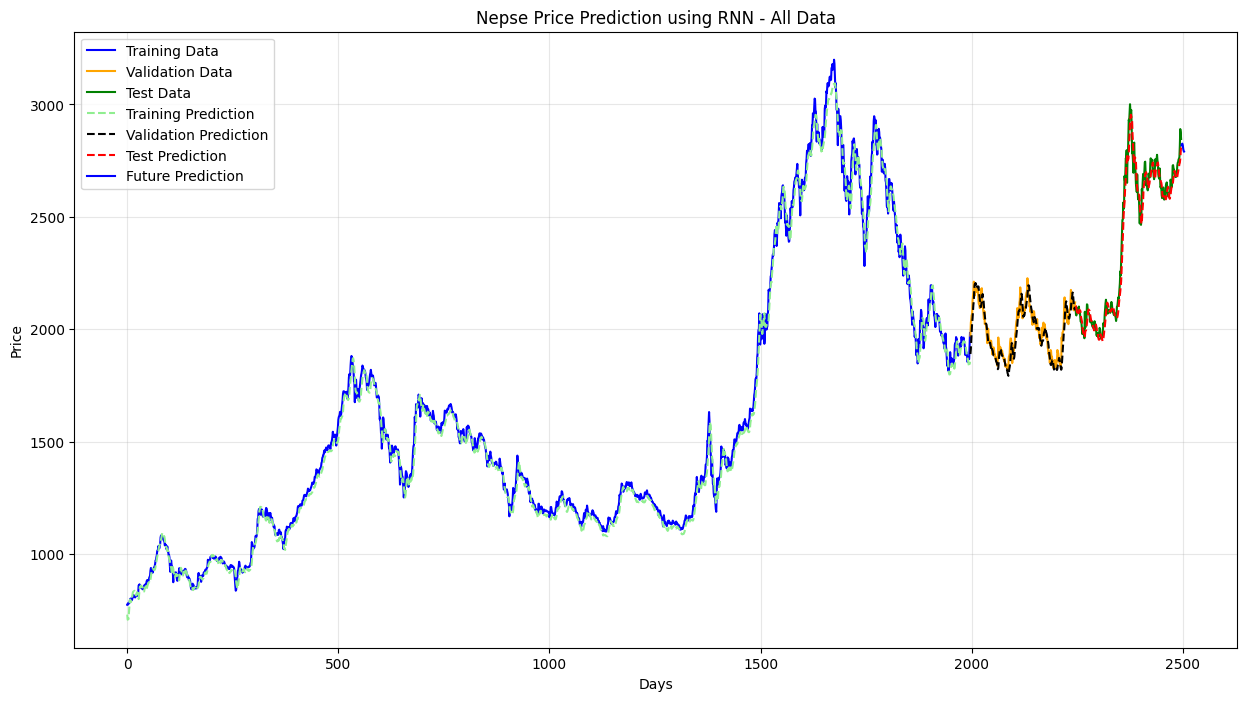

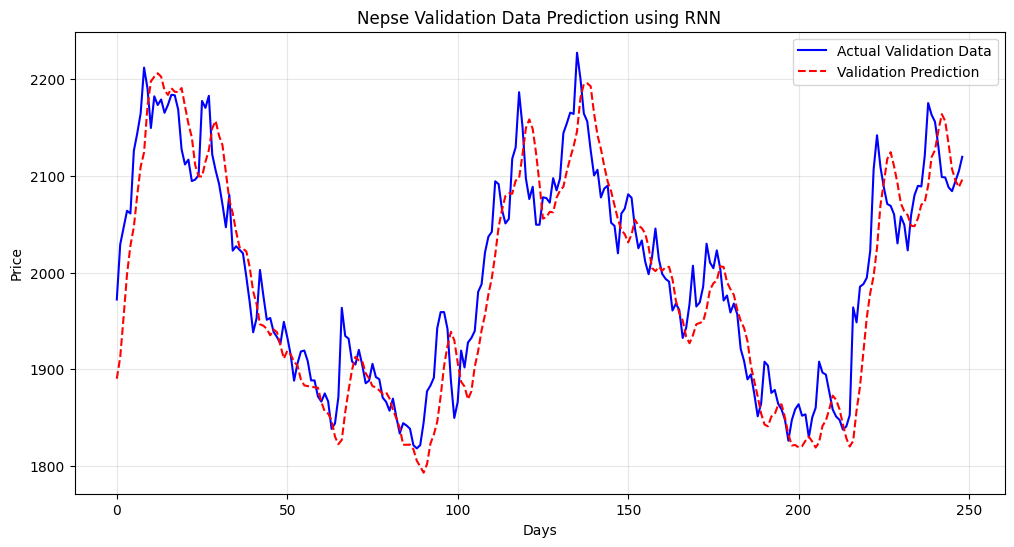

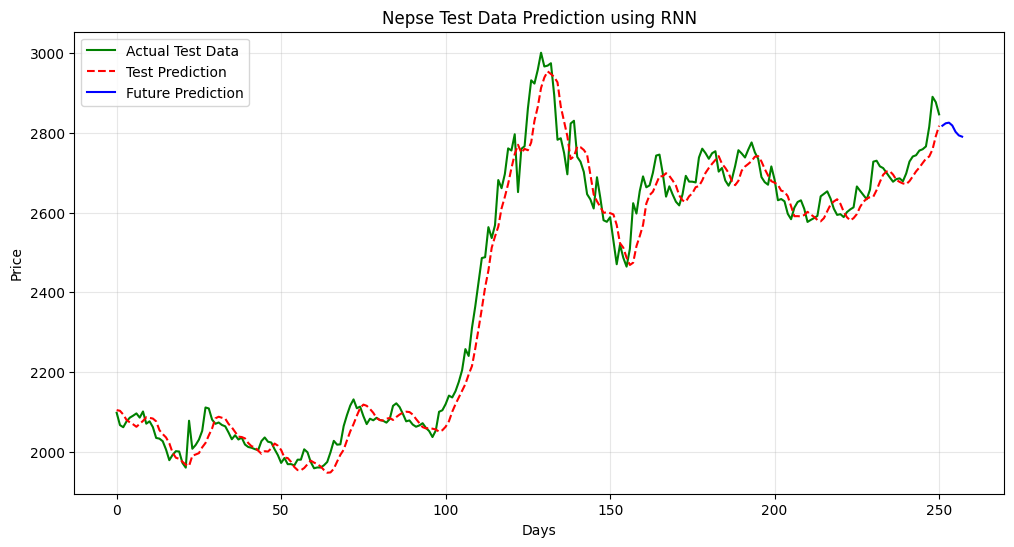


Training LSTM model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0411 - mae: 0.1253
Epoch 1: val_loss improved from inf to 0.00099, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0389 - mae: 0.1205 - val_loss: 9.8693e-04 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 2/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mae: 0.0278
Epoch 2: val_loss improved from 0.00099 to 0.00095, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0017 - mae: 0.0278 - val_loss: 9.5361e-04 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 3/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0268
Epoch 3: val_loss improved from 0.00095 to 0.00079, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 7.8628e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0258
Epoch 4: val_loss improved from 0.00079 to 0.00070, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 6.9547e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 5/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mae: 0.0227
Epoch 5: val_loss did not improve from 0.00070
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0227 - val_loss: 7.2277e-04 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mae: 0.0219
Epoch 6: val_loss improved from 0.00070 to 0.00064, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 6.3713e-04 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 7/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6023e-04 - mae: 0.0212
Epoch 7: val_loss did not improve from 0.00064
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6201e-04 - mae: 0.0212 - val_loss: 0.0013 - val_mae: 0.0287 - learning_rate: 0.0010
Epoch 8/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9994e-04 - mae: 0.0214
Epoch 8: val_loss improved from 0.00064 to 0.00060, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9425e-04 - mae: 0.0213 - val_loss: 6.0267e-04 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 9/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3735e-04 - mae: 0.0184
Epoch 9: val_loss improved from 0.00060 to 0.00053, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4541e-04 - mae: 0.0185 - val_loss: 5.3455e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 10/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0159e-04 - mae: 0.0187
Epoch 10: val_loss improved from 0.00053 to 0.00048, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0618e-04 - mae: 0.0188 - val_loss: 4.8320e-04 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 11/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1525e-04 - mae: 0.0197
Epoch 11: val_loss improved from 0.00048 to 0.00044, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1517e-04 - mae: 0.0197 - val_loss: 4.4134e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 12/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7026e-04 - mae: 0.0189
Epoch 12: val_loss did not improve from 0.00044
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7495e-04 - mae: 0.0190 - val_loss: 4.4147e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 13/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3556e-04 - mae: 0.0190
Epoch 13: val_loss did not improve from 0.00044
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.3673e-04 - mae: 0.0189 - val_loss: 5.8606e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6105e-04 - mae: 0.0189
Epoch 14: val_loss did not improve from 0.00044

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6513e-04 - mae: 0.0190 - val_loss: 5.6271e-04 - val_mae: 0.017

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6977e-04 - mae: 0.0162 - val_loss: 3.7538e-04 - val_mae: 0.0153 - learning_rate: 5.0000e-04
Epoch 20/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7972e-04 - mae: 0.0161
Epoch 20: val_loss did not improve from 0.00038
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8156e-04 - mae: 0.0161 - val_loss: 4.0693e-04 - val_mae: 0.0151 - learning_rate: 5.0000e-04
Epoch 21/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2741e-04 - mae: 0.0157
Epoch 21: val_loss did not improve from 0.00038
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2508e-04 - mae: 0.0157 - val_loss: 3.7980e-04 - val_mae: 0.0151 - learning_rate: 5.0000e-04
Epoch 22/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3341e-04 - mae: 0.0159
Epoch 22: val_loss did not improve from 0.00038
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3537e-04 - mae: 0.0159 - val_loss: 4.7269e-04 - val_mae: 0.0159 - learning_rate: 5.0000e-04
Epoch 23/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0


Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4434e-04 - mae: 0.0158 - val_loss: 3.5758e-04 - val_mae: 0.0149 - learning_rate: 5.0000e-04
Epoch 25/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0516e-04 - mae: 0.0150
Epoch 25: val_loss did not improve from 0.00036
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0364e-04 - mae: 0.0150 - val_loss: 4.0931e-04 - val_mae: 0.0150 - learning_rate: 2.5000e-04
Epoch 26/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4210e-04 - mae: 0.0141
Epoch 26: val_loss improved from 0.00036 to 0.00035, saving model to best_LSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4405e-04 - mae: 0.0142 - val_loss: 3.4603e-04 - val_mae: 0.0153 - learning_rate: 2.5000e-04
Epoch 27/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2194e-04 - mae: 0.0151
Epoch 27: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2074e-04 - mae: 0.0151 - val_loss: 6.4370e-04 - val_mae: 0.0193 - learning_rate: 2.5000e-04
Epoch 28/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0133e-04 - mae: 0.0151
Epoch 28: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0110e-04 - mae: 0.0151 - val_loss: 3.6768e-04 - val_mae: 0.0147 - learning_rate: 2.5000e-04
Epoch 29/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8469e-04 - mae: 0.0150
Epoch 29: val_loss did not improve from 0.00035

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8546e-04 - mae: 0.0150 - val_loss: 4.4779e-04 - val_

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM - Training Data - MAE: 29.4444, MAPE: 1.81%
LSTM - Validation Data - MAE: 37.4991, MAPE: 1.86%
LSTM - Test Data - MAE: 44.9909, MAPE: 1.81%

--------------------------------------------------
Predicting next 7 days using LSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 1 (2025-03-05): Predicted Price = Rs.2810.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 2 (2025-03-06): Predicted Price = Rs.2826.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 3 (2025-03-07): Predicted Price = Rs.2833.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 4 (2025-03-08): Predicted Price = Rs.2834.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 5 (2025-03-09): Predicted Price = Rs.2831.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 6 (2025-03-10): Predicted Price = Rs.2825.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Day 7 (2025-03-11): Predicted Pric

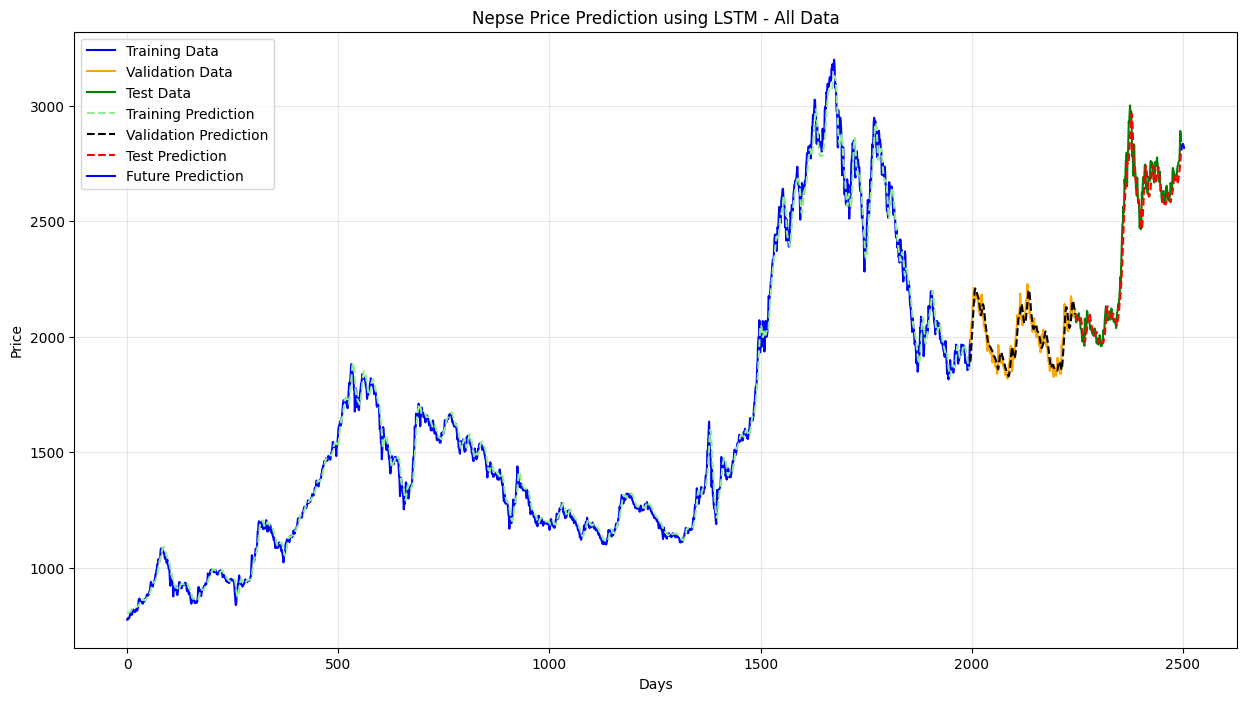

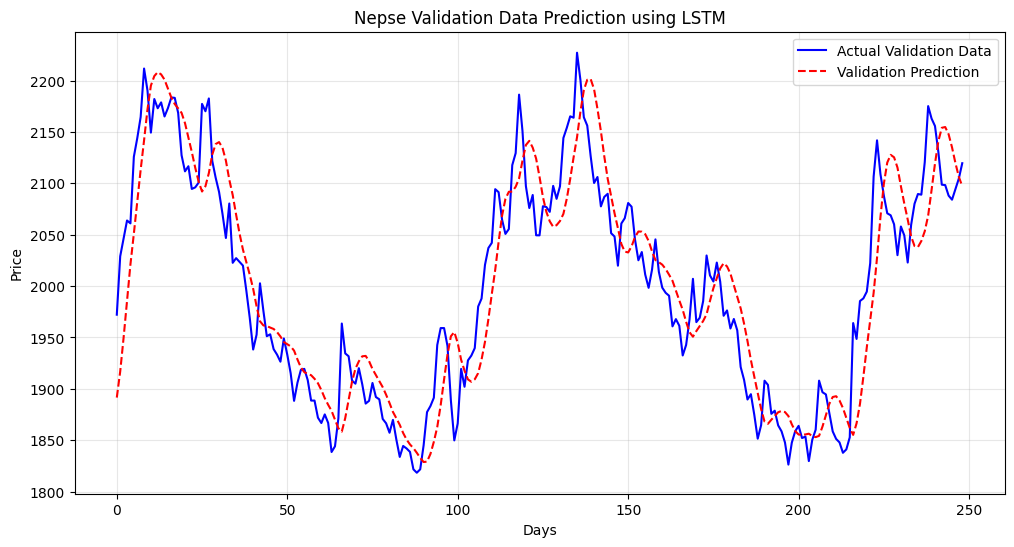

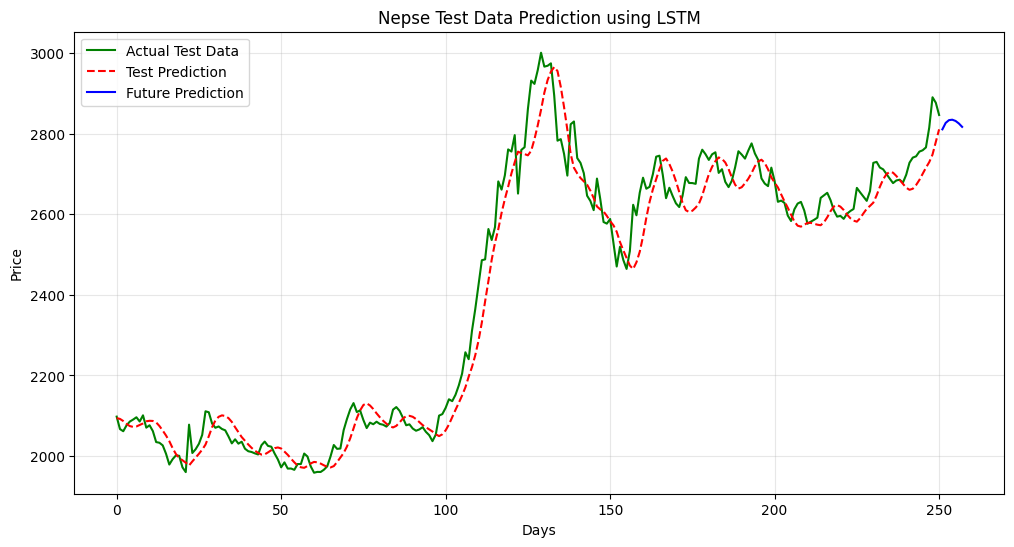


Training GRU model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0661 - mae: 0.1685
Epoch 1: val_loss improved from inf to 0.00044, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0620 - mae: 0.1609 - val_loss: 4.4268e-04 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - mae: 0.0239
Epoch 2: val_loss improved from 0.00044 to 0.00042, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - mae: 0.0239 - val_loss: 4.2155e-04 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 3/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0216
Epoch 3: val_loss did not improve from 0.00042
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - mae: 0.0215 - val_loss: 5.3662e-04 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mae: 0.0226
Epoch 4: val_loss improved from 0.00042 to 0.00033, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0226 - val_loss: 3.3371e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 5/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9599e-04 - mae: 0.0202
Epoch 5: val_loss improved from 0.00033 to 0.00031, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9496e-04 - mae: 0.0202 - val_loss: 3.0743e-04 - val_mae: 0.0134 - learning_rate: 0.0010
Epoch 6/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1850e-04 - mae: 0.0208
Epoch 6: val_loss did not improve from 0.00031
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.1627e-04 - mae: 0.0208 - val_loss: 3.9064e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 7/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8923e-04 - mae: 0.0185
Epoch 7: val_loss did not improve from 0.00031
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8417e-04 - mae: 0.0184 - val_loss: 3.6324e-04 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3859e-04 - mae: 0.0183
Epoch 8: val_loss did not improve from 0.00031
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3822e-04 - mae: 0.0183 - val_loss: 3.9434e-04 - val_mae: 0.0144 - learning_rate: 0.0010
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2209e-04 - mae: 0.0171 - val_loss: 2.5208e-04 - val_mae: 0.0124 - learning_rate: 5.0000e-04
Epoch 11/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9912e-04 - mae: 0.0151
Epoch 11: val_loss improved from 0.00025 to 0.00025, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0038e-04 - mae: 0.0152 - val_loss: 2.5051e-04 - val_mae: 0.0123 - learning_rate: 5.0000e-04
Epoch 12/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6305e-04 - mae: 0.0151
Epoch 12: val_loss did not improve from 0.00025
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7612e-04 - mae: 0.0153 - val_loss: 3.3165e-04 - val_mae: 0.0157 - learning_rate: 5.0000e-04
Epoch 13/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3256e-04 - mae: 0.0167
Epoch 13: val_loss did not improve from 0.00025
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3080e-04 - mae: 0.0167 - val_loss: 3.3736e-04 - val_mae: 0.0133 - learning_rate: 5.0000e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2092e-04 - mae: 0.0150
Epoch 14: val_loss did not improve from 0.00025

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2055e-04 - mae: 0.0150 - val_loss: 3.3939e-04 - val_m

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2435e-04 - mae: 0.0151 - val_loss: 2.2902e-04 - val_mae: 0.0126 - learning_rate: 2.5000e-04
Epoch 18/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3488e-04 - mae: 0.0141
Epoch 18: val_loss improved from 0.00023 to 0.00023, saving model to best_GRU_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3735e-04 - mae: 0.0142 - val_loss: 2.2606e-04 - val_mae: 0.0118 - learning_rate: 2.5000e-04
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2106e-04 - mae: 0.0150
Epoch 19: val_loss did not improve from 0.00023
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2066e-04 - mae: 0.0150 - val_loss: 3.3136e-04 - val_mae: 0.0133 - learning_rate: 2.5000e-04
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4860e-04 - mae: 0.0154
Epoch 20: val_loss did not improve from 0.00023
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4769e-04 - mae: 0.0154 - val_loss: 2.3976e-04 - val_mae: 0.0118 - learning_rate: 2.5000e-04
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4223e-04 - mae: 0.0142
Epoch 21: val_loss did not improve from 0.00023
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4252e-04 - mae: 0.0142 - val_loss: 3.2406e-04 - val_mae: 0.0131 - learning_rate: 2.5000e-04
Epoch 22/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 


Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9987e-04 - mae: 0.0133 - val_loss: 2.1291e-04 - val_mae: 0.0121 - learning_rate: 1.2500e-04
Epoch 28/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7940e-04 - mae: 0.0146
Epoch 28: val_loss did not improve from 0.00021
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7784e-04 - mae: 0.0146 - val_loss: 2.9336e-04 - val_mae: 0.0125 - learning_rate: 6.2500e-05
Epoch 29/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1215e-04 - mae: 0.0135
Epoch 29: val_loss did not improve from 0.00021
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1644e-04 - mae: 0.0136 - val_loss: 3.4726e-04 - val_mae: 0.0138 - learning_rate: 6.2500e-05
Epoch 30/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4159e-04 - mae: 0.0136
Epoch 30: val_loss did not improve from 0.00021
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4149e-04 - mae: 0.0136 - val_loss: 2.3629e-04 - val_m

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
GRU - Training Data - MAE: 26.2610, MAPE: 1.68%
GRU - Validation Data - MAE: 29.4625, MAPE: 1.47%
GRU - Test Data - MAE: 35.8272, MAPE: 1.44%

--------------------------------------------------
Predicting next 7 days using GRU model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 1 (2025-03-05): Predicted Price = Rs.2831.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Day 2 (2025-03-06): Predicted Price = Rs.2831.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 3 (2025-03-07): Predicted Price = Rs.2824.18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 4 (2025-03-08): Predicted Price = Rs.2815.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 5 (2025-03-09): Predicted Price = Rs.2806.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 6 (2025-03-10): Predicted Price = Rs.2798.14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 7 (2025-03-11): Predicted Price = 

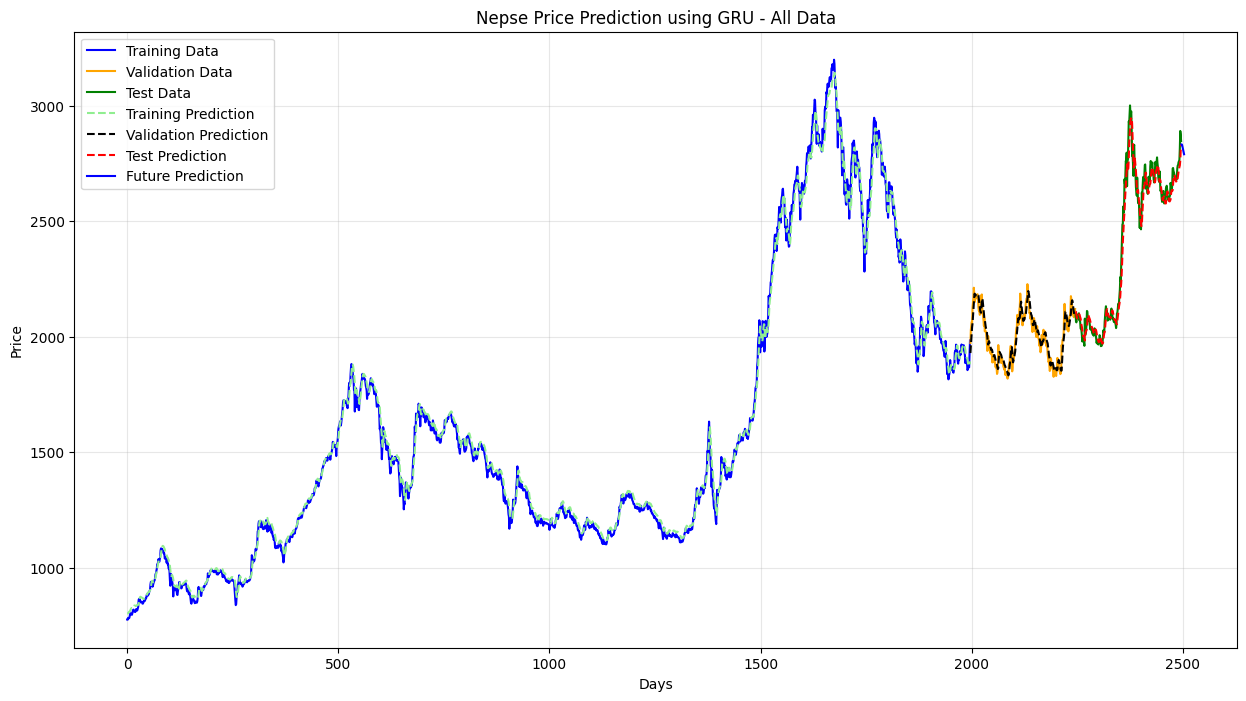

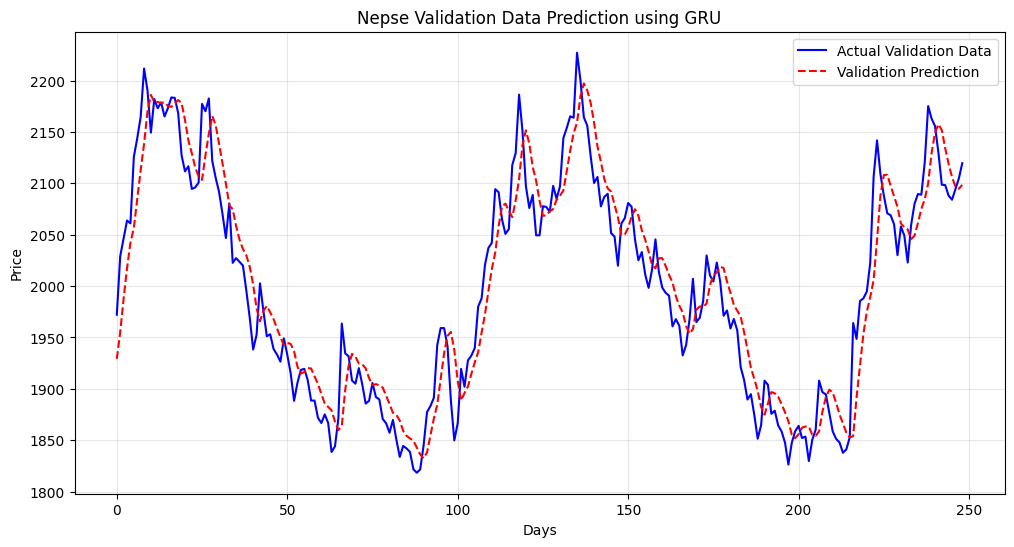

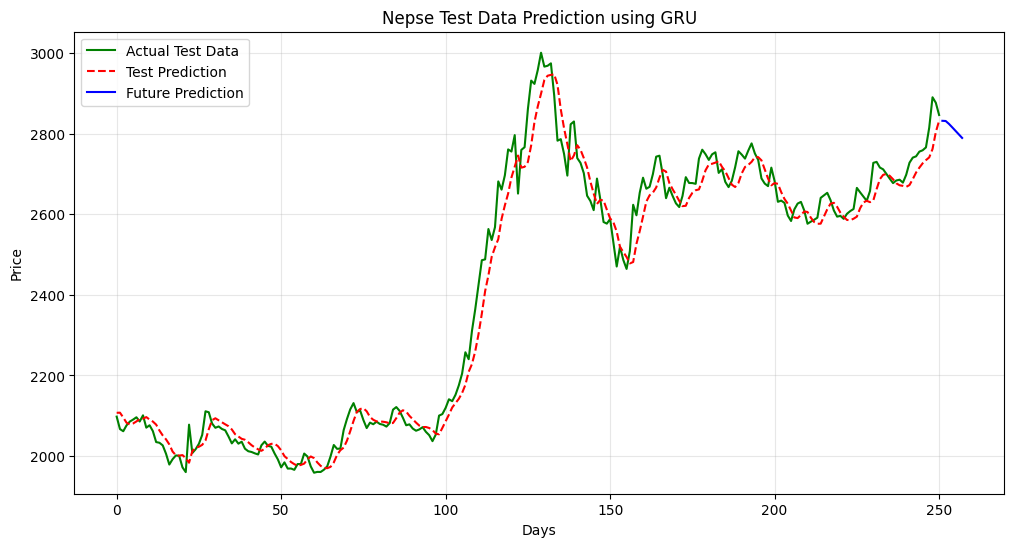


Training BiLSTM model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,769 (534.25 KB)

 Trainable params: 136,769 (534.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0259 - mae: 0.1023
Epoch 1: val_loss improved from inf to 0.00132, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0248 - mae: 0.0996 - val_loss: 0.0013 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 2/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - mae: 0.0290
Epoch 2: val_loss did not improve from 0.00132
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0023 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - mae: 0.0255
Epoch 3: val_loss improved from 0.00132 to 0.00081, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 8.1485e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - mae: 0.0230
Epoch 4: val_loss improved from 0.00081 to 0.00053, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 5.2910e-04 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 5/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3691e-04 - mae: 0.0204
Epoch 5: val_loss improved from 0.00053 to 0.00045, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2714e-04 - mae: 0.0203 - val_loss: 4.5330e-04 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 6/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2601e-04 - mae: 0.0190
Epoch 6: val_loss did not improve from 0.00045
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.3076e-04 - mae: 0.0190 - val_loss: 5.2233e-04 - val_mae: 0.0201 - learning_rate: 0.0010
Epoch 7/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7277e-04 - mae: 0.0206
Epoch 7: val_loss improved from 0.00045 to 0.00043, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.7340e-04 - mae: 0.0206 - val_loss: 4.2848e-04 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 8/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9233e-04 - mae: 0.0168
Epoch 8: val_loss improved from 0.00043 to 0.00042, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.9435e-04 - mae: 0.0168 - val_loss: 4.1809e-04 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 9/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3323e-04 - mae: 0.0174
Epoch 9: val_loss did not improve from 0.00042
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3747e-04 - mae: 0.0175 - val_loss: 5.4450e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 10/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6836e-04 - mae: 0.0176
Epoch 10: val_loss did not improve from 0.00042
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6887e-04 - mae: 0.0176 - val_loss: 4.3813e-04 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 11/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.8447e-04 - mae: 0.0164
Epoch 11: val_loss did not improve from 0.00042
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.8530e-04 - mae: 0.0164 - val_loss: 4.5192e-04 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9720e-04 - mae: 0.0152 - val_loss: 3.7492e-04 - val_mae: 0.0164 - learning_rate: 5.0000e-04
Epoch 14/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0921e-04 - mae: 0.0141
Epoch 14: val_loss improved from 0.00037 to 0.00035, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1185e-04 - mae: 0.0142 - val_loss: 3.4736e-04 - val_mae: 0.0156 - learning_rate: 5.0000e-04
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6268e-04 - mae: 0.0149
Epoch 15: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.6259e-04 - mae: 0.0149 - val_loss: 4.4752e-04 - val_mae: 0.0154 - learning_rate: 5.0000e-04
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8391e-04 - mae: 0.0150
Epoch 16: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8373e-04 - mae: 0.0150 - val_loss: 3.9084e-04 - val_mae: 0.0173 - learning_rate: 5.0000e-04
Epoch 17/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8631e-04 - mae: 0.0152
Epoch 17: val_loss did not improve from 0.00035

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8838e-04 - mae: 0.0152 - val_loss: 3.6622e-04 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.5094e-04 - mae: 0.0141 - val_loss: 3.2064e-04 - val_mae: 0.0144 - learning_rate: 2.5000e-04
Epoch 20/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6798e-04 - mae: 0.0146
Epoch 20: val_loss improved from 0.00032 to 0.00032, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6816e-04 - mae: 0.0146 - val_loss: 3.1865e-04 - val_mae: 0.0144 - learning_rate: 2.5000e-04
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0179e-04 - mae: 0.0139
Epoch 21: val_loss did not improve from 0.00032
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0243e-04 - mae: 0.0139 - val_loss: 3.2096e-04 - val_mae: 0.0146 - learning_rate: 2.5000e-04
Epoch 22/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2306e-04 - mae: 0.0143
Epoch 22: val_loss did not improve from 0.00032
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2284e-04 - mae: 0.0142 - val_loss: 3.8933e-04 - val_mae: 0.0145 - learning_rate: 2.5000e-04
Epoch 23/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5194e-04 - mae: 0.0131
Epoch 23: val_loss did not improve from 0.00032
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5314e-04 - mae: 0.0131 - val_loss: 3.4243e-04 - val_mae: 0.0141 - learning_rate: 2.5000e-04
Epoch 24/50
60/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0376e-04 - mae: 0.0135 - val_loss: 3.1258e-04 - val_mae: 0.0142 - learning_rate: 1.2500e-04
Epoch 27/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3754e-04 - mae: 0.0138
Epoch 27: val_loss did not improve from 0.00031
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3590e-04 - mae: 0.0138 - val_loss: 4.0620e-04 - val_mae: 0.0147 - learning_rate: 1.2500e-04
Epoch 28/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9603e-04 - mae: 0.0134
Epoch 28: val_loss improved from 0.00031 to 0.00030, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.9647e-04 - mae: 0.0134 - val_loss: 3.0075e-04 - val_mae: 0.0143 - learning_rate: 1.2500e-04
Epoch 29/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9918e-04 - mae: 0.0132
Epoch 29: val_loss did not improve from 0.00030

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9870e-04 - mae: 0.0132 - val_loss: 3.0385e-04 - val_mae: 0.0146 - learning_rate: 1.2500e-04
Epoch 30/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2505e-04 - mae: 0.0142
Epoch 30: val_loss did not improve from 0.00030
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2481e-04 - mae: 0.0142 - val_loss: 3.1658e-04 - val_mae: 0.0136 - learning_rate: 6.2500e-05
Epoch 31/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5498e-04 - mae: 0.0128
Epoch 31: val_loss did not improve from 0.00030
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5506e-04 - mae: 0.0128 - val_loss: 3.0133e-04 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6455e-04 - mae: 0.0133 - val_loss: 2.9852e-04 - val_mae: 0.0144 - learning_rate: 6.2500e-05
Epoch 33/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6723e-04 - mae: 0.0130
Epoch 33: val_loss did not improve from 0.00030
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6791e-04 - mae: 0.0130 - val_loss: 3.0483e-04 - val_mae: 0.0140 - learning_rate: 6.2500e-05
Epoch 34/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5660e-04 - mae: 0.0130
Epoch 34: val_loss did not improve from 0.00030

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.5666e-04 - mae: 0.0130 - val_loss: 3.0663e-04 - val_mae: 0.0137 - learning_rate: 6.2500e-05
Epoch 35/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7730e-04 - mae: 0.0131
Epoch 35: val_loss improved from 0.00030 to 0.00030, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7820e-04 - mae: 0.0131 - val_loss: 2.9693e-04 - val_mae: 0.0137 - learning_rate: 3.1250e-05
Epoch 36/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9935e-04 - mae: 0.0131
Epoch 36: val_loss improved from 0.00030 to 0.00030, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.9906e-04 - mae: 0.0131 - val_loss: 2.9593e-04 - val_mae: 0.0141 - learning_rate: 3.1250e-05
Epoch 37/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3225e-04 - mae: 0.0124
Epoch 37: val_loss did not improve from 0.00030
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3559e-04 - mae: 0.0124 - val_loss: 3.0462e-04 - val_mae: 0.0136 - learning_rate: 3.1250e-05
Epoch 38/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1246e-04 - mae: 0.0135
Epoch 38: val_loss improved from 0.00030 to 0.00029, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1150e-04 - mae: 0.0135 - val_loss: 2.9462e-04 - val_mae: 0.0137 - learning_rate: 3.1250e-05
Epoch 39/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7504e-04 - mae: 0.0128
Epoch 39: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5



Epoch 39: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7654e-04 - mae: 0.0129 - val_loss: 2.9448e-04 - val_mae: 0.0137 - learning_rate: 3.1250e-05
Epoch 40/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6930e-04 - mae: 0.0130
Epoch 40: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6960e-04 - mae: 0.0131 - val_loss: 2.9384e-04 - val_mae: 0.0137 - learning_rate: 1.5625e-05
Epoch 41/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0389e-04 - mae: 0.0135
Epoch 41: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0162e-04 - mae: 0.0135 - val_loss: 2.9203e-04 - val_mae: 0.0139 - learning_rate: 1.5625e-05
Epoch 42/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1956e-04 - mae: 0.0134
Epoch 42: val_loss did not improve from 0.00029
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1678e-04 - mae: 0.0134 - val_loss: 2.9840e-04 - val_mae: 0.0144 - learning_rate: 1.5625e-05
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4466e-04 - mae: 0.0142
Epoch 43: val_loss did not improve from 0.00029
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4319e-04 - mae: 0.0142 - val_loss: 2.9428e-04 - val_mae: 0.0136 - learning_rate: 1.5625e-05
Epoch 44/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5172e-04 - mae: 0.0126
Epoch 44: val_loss did not improve from 0.00029

Epoch 44: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5259e-04 - mae: 0.0127 - val_loss: 3.0587e-04 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3897e-04 - mae: 0.0123 - val_loss: 2.9179e-04 - val_mae: 0.0139 - learning_rate: 7.8125e-06
Epoch 49/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4997e-04 - mae: 0.0129
Epoch 49: val_loss did not improve from 0.00029

Epoch 49: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5017e-04 - mae: 0.0129 - val_loss: 2.9501e-04 - val_mae: 0.0136 - learning_rate: 7.8125e-06
Epoch 50/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5734e-04 - mae: 0.0128
Epoch 50: val_loss did not improve from 0.00029
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5737e-04 - mae: 0.0128 - val_loss: 2.9308e-04 - val_mae: 0.0137 - learning_rate: 3.9063e-06


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
BiLSTM - Training Data - MAE: 25.2102, MAPE: 1.54%
BiLSTM - Validation Data - MAE: 34.0161, MAPE: 1.69%
BiLSTM - Test Data - MAE: 38.8982, MAPE: 1.57%

--------------------------------------------------
Predicting next 7 days using BiLSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Day 1 (2025-03-05): Predicted Price = Rs.2826.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Day 2 (2025-03-06): Predicted Price = Rs.2836.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 3 (2025-03-07): Predicted Price = Rs.2843.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 4 (2025-03-08): Predicted Price = Rs.2847.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 5 (2025-03-09): Predicted Price = Rs.2849.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Day 6 (2025-03-10): Predicted Price = Rs.2849.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Day 7 (2025-03-11): Predic

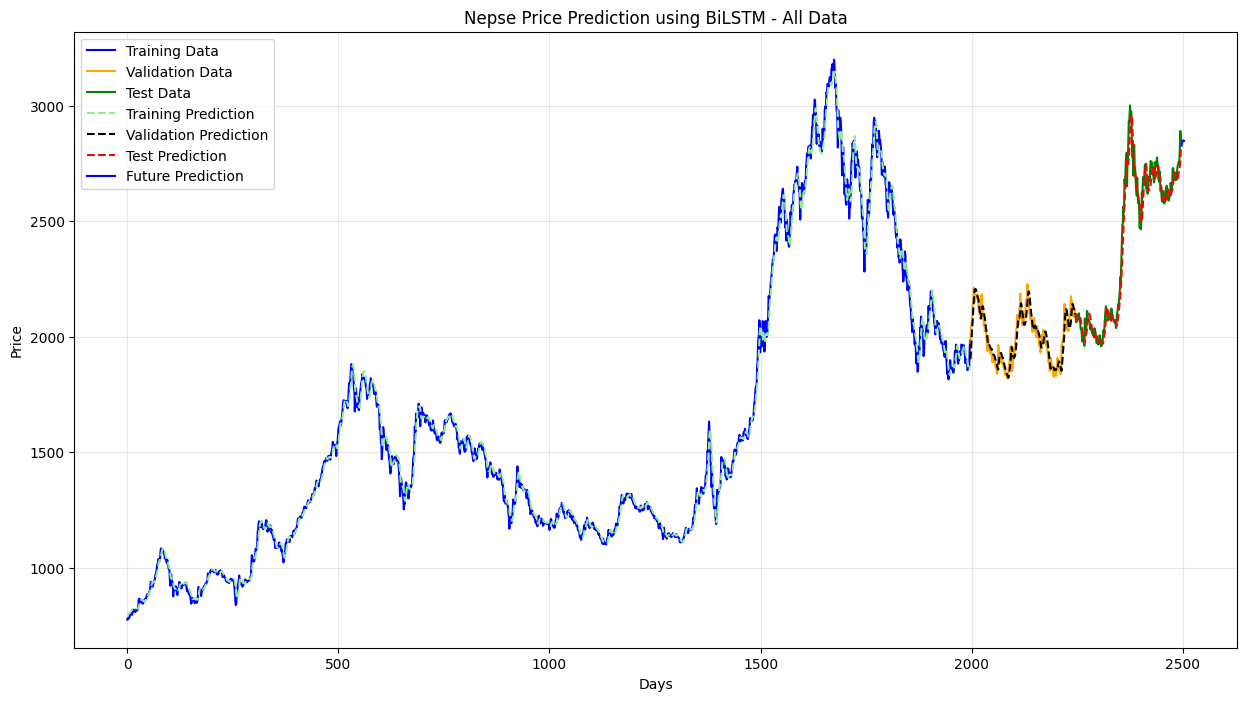

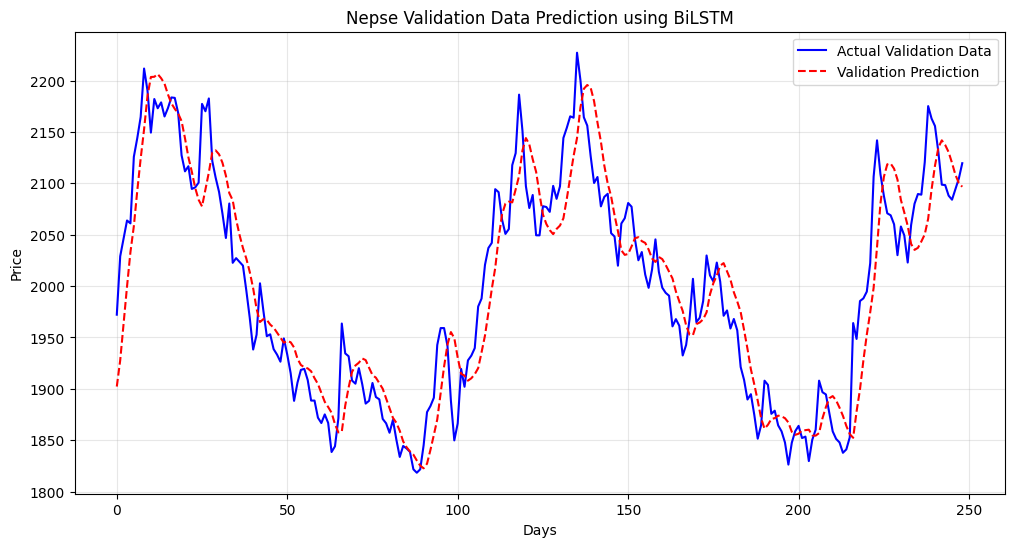

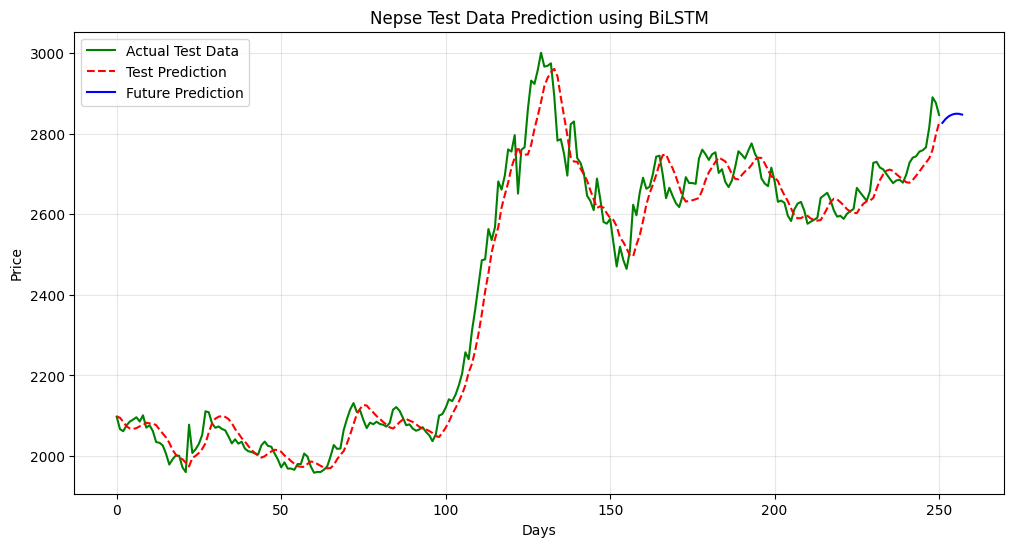


Training Transformer model...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 30, 64)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding                  │ (None, 30, 64)              │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_5 (Functional)            │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,641 (658.75 KB)

 Trainable params: 168,641 (658.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2517 - mae: 0.3074
Epoch 1: val_loss improved from inf to 0.00217, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.2491 - mae: 0.3052 - val_loss: 0.0022 - val_mae: 0.0364 - learning_rate: 0.0010
Epoch 2/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - mae: 0.0445
Epoch 2: val_loss did not improve from 0.00217
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0445 - val_loss: 0.0034 - val_mae: 0.0498 - learning_rate: 0.0010
Epoch 3/50
54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - mae: 0.0492
Epoch 3: val_loss improved from 0.00217 to 0.00143, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mae: 0.0490 - val_loss: 0.0014 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 4/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0396
Epoch 4: val_loss did not improve from 0.00143
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0397 - val_loss: 0.0016 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 5/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0373
Epoch 5: val_loss improved from 0.00143 to 0.00141, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mae: 0.0372 - val_loss: 0.0014 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 6/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0371
Epoch 6: val_loss improved from 0.00141 to 0.00058, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - mae: 0.0370 - val_loss: 5.7685e-04 - val_mae: 0.0207 - learning_rate: 0.0010
Epoch 7/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0355
Epoch 7: val_loss improved from 0.00058 to 0.00035, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mae: 0.0356 - val_loss: 3.5295e-04 - val_mae: 0.0155 - learning_rate: 0.0010
Epoch 8/50
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0345
Epoch 8: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0344 - val_loss: 0.0021 - val_mae: 0.0430 - learning_rate: 0.0010
Epoch 9/50
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0290
Epoch 9: val_loss did not improve from 0.00035
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0289 - val_loss: 7.4770e-04 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 10/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0260
Epoch 10: val_loss improved from 0.00035 to 0.00019, saving model to best_Transformer_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 1.9259e-04 - val_mae: 0.0109 - learning_rate: 0.0010
Epoch 11/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.3491e-04 - mae: 0.0243
Epoch 11: val_loss did not improve from 0.00019
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4302e-04 - mae: 0.0244 - val_loss: 2.0886e-04 - val_mae: 0.0117 - learning_rate: 0.0010
Epoch 12/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8637e-04 - mae: 0.0234
Epoch 12: val_loss did not improve from 0.00019
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8828e-04 - mae: 0.0234 - val_loss: 0.0012 - val_mae: 0.0325 - learning_rate: 0.0010
Epoch 13/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mae: 0.0277
Epoch 13: val_loss did not improve from 0.00019
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0275 - val_loss: 6.6648e-04 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 14/50
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3645e-04 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6646e-04 - mae: 0.0186 - val_loss: 1.5353e-04 - val_mae: 0.0094 - learning_rate: 5.0000e-04
Epoch 19/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0012e-04 - mae: 0.0210
Epoch 19: val_loss did not improve from 0.00015
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9823e-04 - mae: 0.0210 - val_loss: 4.3873e-04 - val_mae: 0.0185 - learning_rate: 5.0000e-04
Epoch 20/50
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2734e-04 - mae: 0.0182
Epoch 20: val_loss did not improve from 0.00015

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2843e-04 - mae: 0.0182 - val_loss: 4.0739e-04 - val_mae: 0.0176 - learning_rate: 5.0000e-04
Epoch 21/50
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5161e-04 - mae: 0.0167
Epoch 21: val_loss did not improve from 0.00015
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5685e-04 - mae: 0.0168 - val_loss: 1.9637e-04 - val_ma

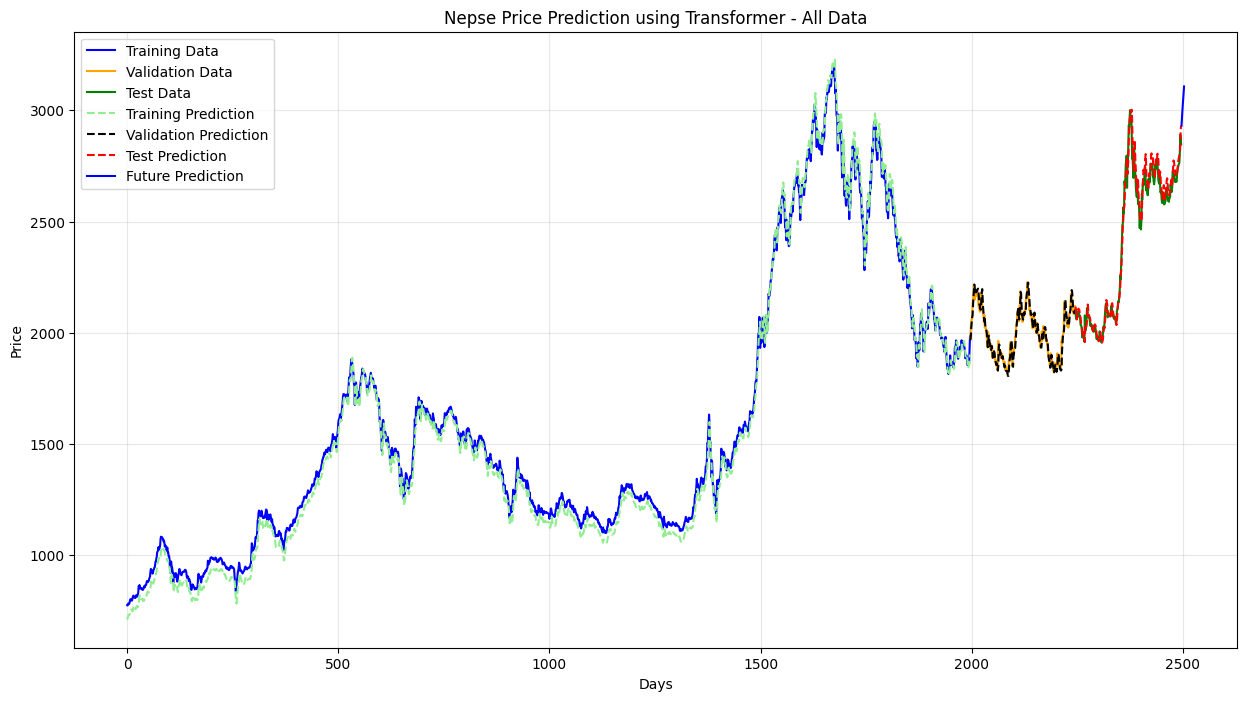

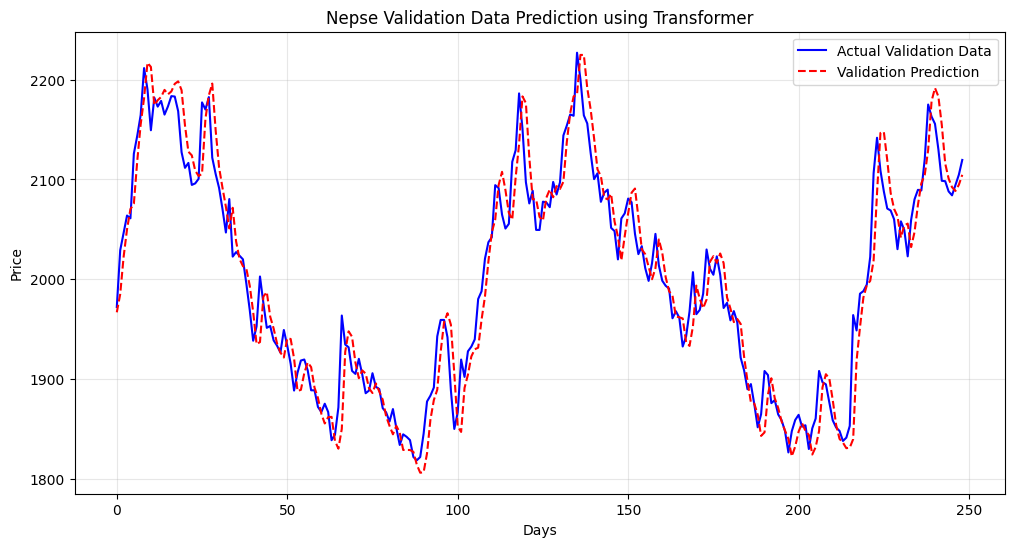

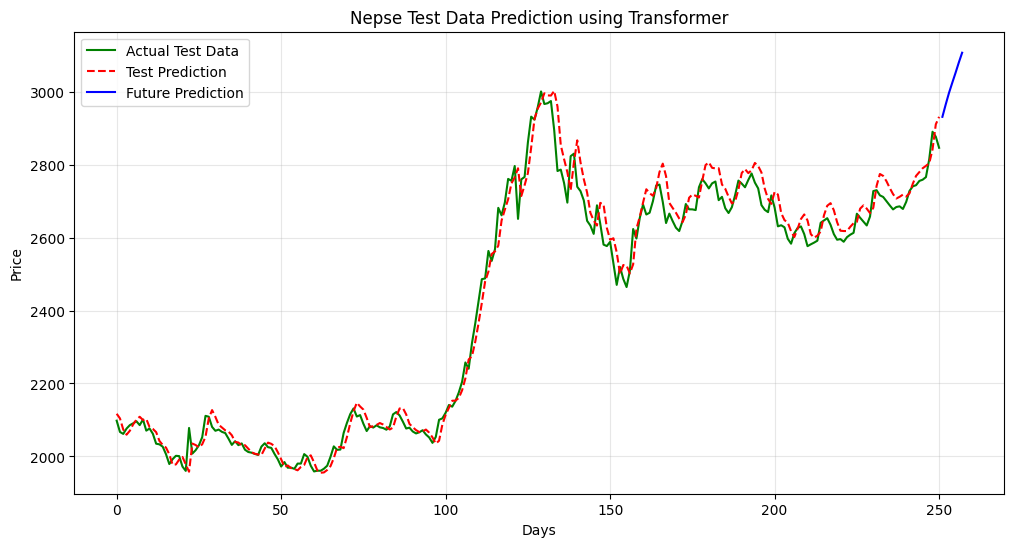


Model Performance Comparison:
         Model  Train MAE  Train MAPE (%)    Val MAE  Val MAPE (%)   Test MAE  \
0          RNN  30.181265        1.908930  34.293815      1.700720  37.729802   
1         LSTM  29.444368        1.812212  37.499128      1.860989  44.990935   
2          GRU  26.260954        1.679462  29.462476      1.468757  35.827197   
3       BiLSTM  25.210219        1.536282  34.016084      1.686866  38.898186   
4  Transformer  39.102720        2.880175  22.905759      1.137471  31.826773   

   Test MAPE (%)  
0       1.525369  
1       1.807944  
2       1.438189  
3       1.568048  
4       1.273040  


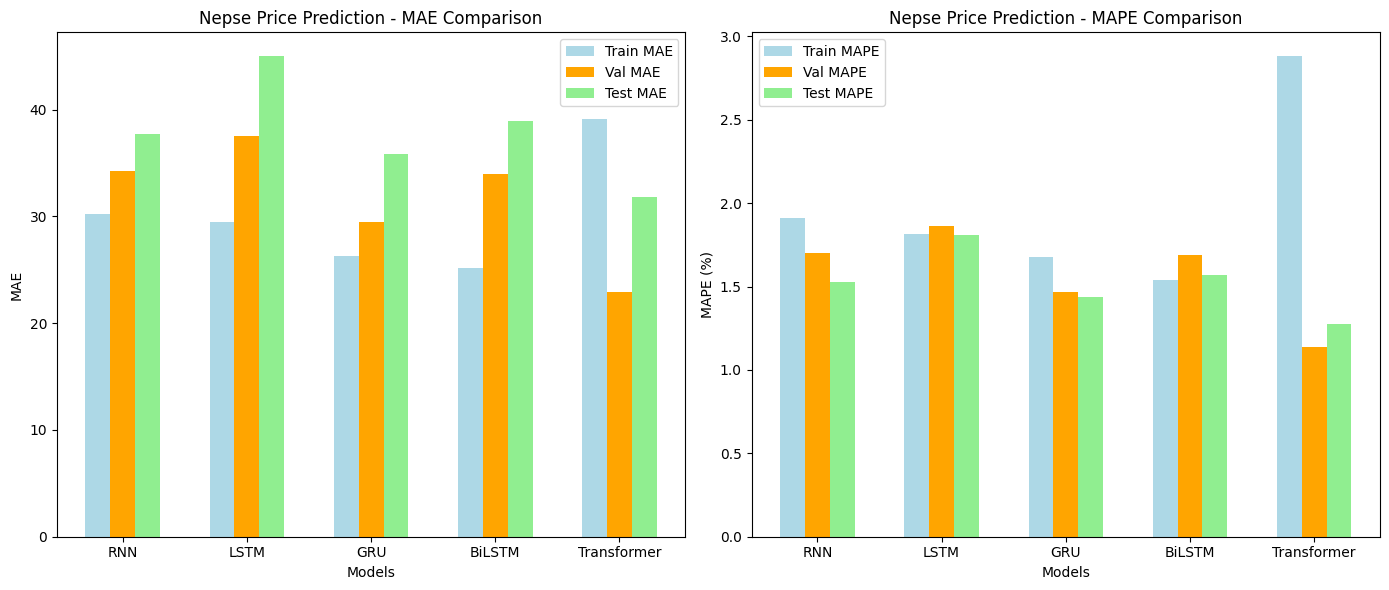

In [12]:
results, metrics, future_df = run_models(
    X_train, y_train, X_val, y_val, X_test, y_test,
    sequence_length=sequence_length,
    scaler=scaler,
    epochs=50,
    batch_size=32,
    stock_name="Nepse"
)